In [1]:
import os
import yaml
from dotenv import load_dotenv

from langgraph.graph import StateGraph,  START, END
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

load_dotenv(override=True)

True

In [2]:
from tools.analisi_asset import *
from tools.analisi_compset import *
from tools.compset import *

from utils.states import AgentState

### Create model as Brain

In [3]:
model = AzureChatOpenAI(
    azure_deployment=os.getenv("AZURE_OPENAI_MODEL"),
    api_version=os.getenv("OPENAI_API_VERSION"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"))

### Create Tools

In [4]:
tools_for_analisi_asset = [get_city_coordinates, get_asset_coordinates, calculate_distance_to_city_centers]
tools_for_compset = [add, multiply, divide]
tools_for_analisi_compset = [add, multiply, divide]

model_with_tools_for_analisi_asset   = model.bind_tools(tools_for_analisi_asset, parallel_tool_calls=False)
model_with_tools_for_compset         = model.bind_tools(tools_for_compset, parallel_tool_calls=False)
model_with_tools_for_analisi_compset = model.bind_tools(tools_for_analisi_compset, parallel_tool_calls=False)

In [5]:
# Import prompts
with open("prompts/analisi_asset.yaml", 'r') as stream:
    analisi_asset_prompt = yaml.safe_load(stream)


# Create system message for Agents
sys_msg_analisi_asset = SystemMessage(content=analisi_asset_prompt['system_prompt'])
sys_msg_compset = SystemMessage(content=""" """)
sys_msg_analisi_compset = SystemMessage(content=""" """)

In [6]:
######################## ANALISI ASSET AGENT ###################################################
def analisi_asset_agent(state: AgentState):
   messages = [model_with_tools_for_analisi_asset.invoke([sys_msg_analisi_asset] + state["messages"])]
   analisi_asset_result = messages[-1]
   return {"messages": messages ,"analisi_asset_result": analisi_asset_result}

######################## COMPSET AGENT #########################################################
def compset_agent(state: AgentState):
   messages = [model_with_tools_for_compset.invoke([sys_msg_compset] + state["messages"])]
   compset_result = messages[-1]
   return {"messages": messages, "compset_result": compset_result}

######################## ANALISI COMPSET AGENT #################################################
def analisi_compset_agent(state: AgentState):
   # Construct the final answer from the arguments of the last call
   messages = [model_with_tools_for_analisi_compset.invoke([sys_msg_analisi_compset] + state["messages"])]
   analisi_compset_result = messages[-1]
   return {"messages": messages, "analisi_compset_result": analisi_compset_result}



# Define the function that determines whether to continue or not.
# if not go to other agent
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if last_message.tool_calls:
        return "continue"
    # Otherwise we will use the tool node again
    else:
        return "next_agent"

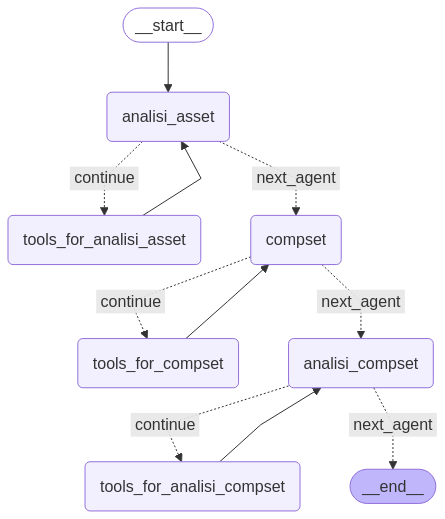

In [7]:
# Initialize Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work for the Agent 
builder.add_node("analisi_asset", analisi_asset_agent)
builder.add_node("tools_for_analisi_asset", ToolNode(tools_for_analisi_asset))

builder.add_node("compset", compset_agent)
builder.add_node("tools_for_compset", ToolNode(tools_for_compset))

builder.add_node("analisi_compset", analisi_compset_agent)
builder.add_node("tools_for_analisi_compset", ToolNode(tools_for_analisi_compset))

#builder.add_node("respond",response_analisi_asset)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "analisi_asset")
builder.add_conditional_edges(
    "analisi_asset",
    should_continue,
    {
        "continue": "tools_for_analisi_asset",
        "next_agent": "compset",
    },
)
builder.add_edge("tools_for_analisi_asset", "analisi_asset")

builder.add_conditional_edges(
    "compset",
    should_continue,
    {
        "continue": "tools_for_compset",
        "next_agent": "analisi_compset",
    },
)

builder.add_edge("tools_for_compset", "compset")

builder.add_conditional_edges(
    "analisi_compset",
    should_continue,
    {
        "continue": "tools_for_analisi_compset",
        "next_agent": END,
    },
)

builder.add_edge("tools_for_analisi_compset", "analisi_compset")
#builder.add_edge("respond", END)

react_graph = builder.compile()


# Show
from langchain_core.runnables.graph import CurveStyle,    Edge,    MermaidDrawMethod,    Node,    NodeStyles
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="You need to analyze the hotel Les Terraces d'Eze ")]
messages = react_graph.invoke({"messages": messages}, interrupt_before="analisi_compset")
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

You need to analyze the hotel Les Terraces d'Eze 
================================== Ai Message ==================================
Tool Calls:
  get_asset_coordinates (call_RZ2SOnNIDYUSWFpkxmjNonTG)
 Call ID: call_RZ2SOnNIDYUSWFpkxmjNonTG
  Args:
    asset_name: Les Terraces d'Eze
    city: Eze
================================= Tool Message =================================
Name: get_asset_coordinates

{"latitude": 43.7329319, "longitude": 7.377233599999999}
================================== Ai Message ==================================
Tool Calls:
  get_city_coordinates (call_phFbpWXlR9XIpWRL0NvcZOuD)
 Call ID: call_phFbpWXlR9XIpWRL0NvcZOuD
  Args:
    city: Monaco
================================= Tool Message =================================
Name: get_city_coordinates

{"latitude": 43.73841760000001, "longitude": 7.424615799999999}
================================== Ai Message =======================

In [12]:
messages['messages'][-1].pretty_print()

================================== Ai Message ==================================

### Asset Analysis for Les Terraces d'Eze

#### 1. Geographic Location Assessment

**Location and Nearby Cities:**
- **Hotel Coordinates:** Latitude 43.7329319, Longitude 7.377233599999999
- **Nearby Major Cities:**
  - **Monaco** (9.127 km away)
  - **Nice** (17.147 km away)
  - **Cannes** (51.064 km away)

**Luxury Hotel Presence and Order by Distance:**
1. **Monaco:** Known for its luxury hotels and casinos.
2. **Nice:** Offers several luxury accommodations and cultural attractions.
3. **Cannes:** Hosts the famous Cannes Film Festival and has luxury hotels along the Riviera.

**Connectivity:**
- **From Monaco to Les Terraces d'Eze:** Approximately 20 minutes by car via A8 or about 30-40 minutes via public transportation including train and bus.
- **From Nice to Les Terraces d'Eze:** Approximately 30 minutes by car via A8, or around 45-60 minutes by train and bus.
- **From Cannes to Les Terraces d'Eze:*